## Pacotes utilizados

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.6


In [2]:
# Gerais para manipulação de Dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Pré processamento e engenharia de atributos
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn import svm
import sklearn
import joblib
import time

In [4]:
# Versões dos pacotes usados neste jupyter notebook

%reload_ext watermark
%watermark -a "Mentoria DSA 2021 - Turma 43" --iversions

Author: Mentoria DSA 2021 - Turma 43

numpy     : 1.21.2
matplotlib: 3.4.3
seaborn   : 0.11.2
sklearn   : 0.0
pandas    : 1.3.2
joblib    : 1.0.1



## Carregamento dos dados

In [5]:
df_original = pd.read_csv('../DataSets/dfPrecoMensal_AnoMes.csv', sep = ",", decimal='.', error_bad_lines=False)

In [6]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1582482 entries, 0 to 1582481
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ano_mes          1582482 non-null  object 
 1   contratacao      1582482 non-null  object 
 2   segmentacao      1582482 non-null  object 
 3   in_odonto        1582482 non-null  int64  
 4   in_obstetricia   1582482 non-null  int64  
 5   tipo             1582482 non-null  object 
 6   abrangencia      1582482 non-null  object 
 7   fator            1582482 non-null  object 
 8   acomodacao       1582482 non-null  object 
 9   internacao       1582482 non-null  object 
 10  cd_faixa_etaria  1582482 non-null  int64  
 11  nm_regiao        1582482 non-null  object 
 12  mensalidade      1582482 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 157.0+ MB


#### Variáveis ``explanatórias``

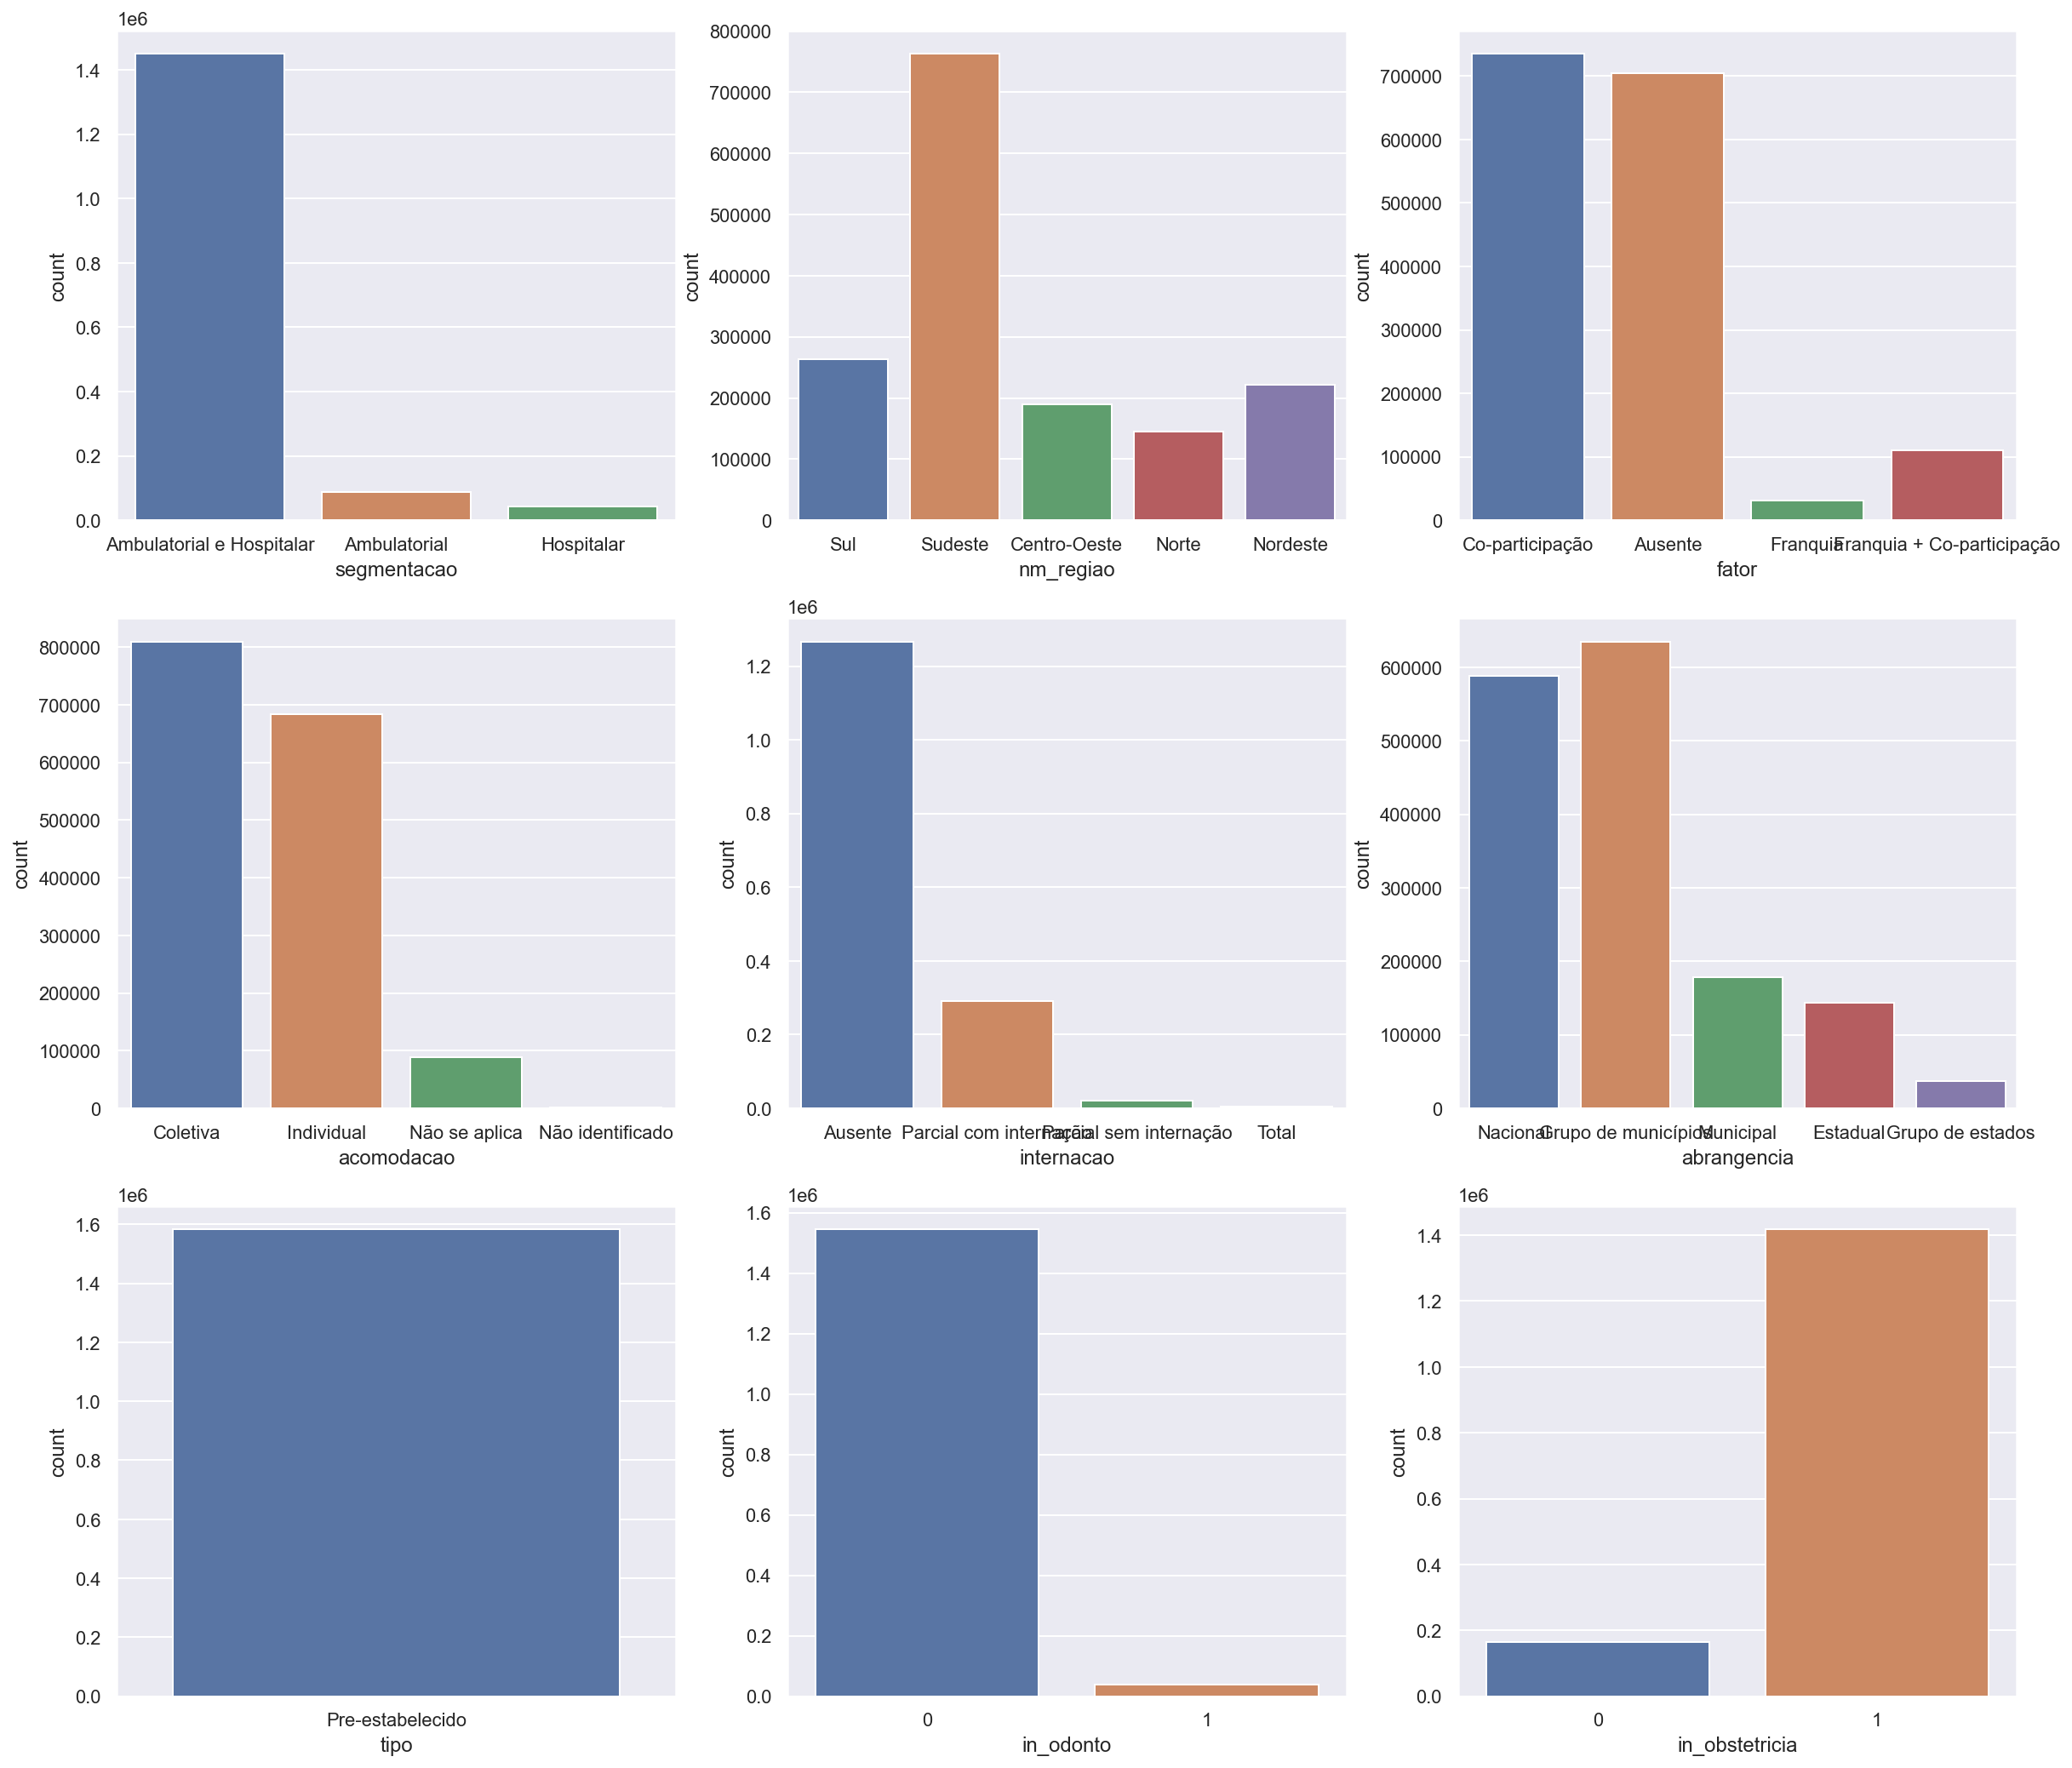

In [7]:
sns.set()
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

_, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 18))

sns.countplot(x="segmentacao", data=df_original, ax=axes[0][0])
sns.countplot(x="nm_regiao", data=df_original, ax=axes[0][1])
sns.countplot(x="fator", data=df_original, ax=axes[0][2]);
sns.countplot(x="acomodacao", data=df_original, ax=axes[1][0]);
sns.countplot(x="internacao", data=df_original, ax=axes[1][1]);
sns.countplot(x="abrangencia", data=df_original, ax=axes[1][2]);
sns.countplot(x="tipo", data=df_original, ax=axes[2][0]);
sns.countplot(x="in_odonto", data=df_original, ax=axes[2][1]);
sns.countplot(x="in_obstetricia", data=df_original, ax=axes[2][2]);

#### Variável ``target``

Text(0.5, 1.0, 'Boxplot - Mensalidade')

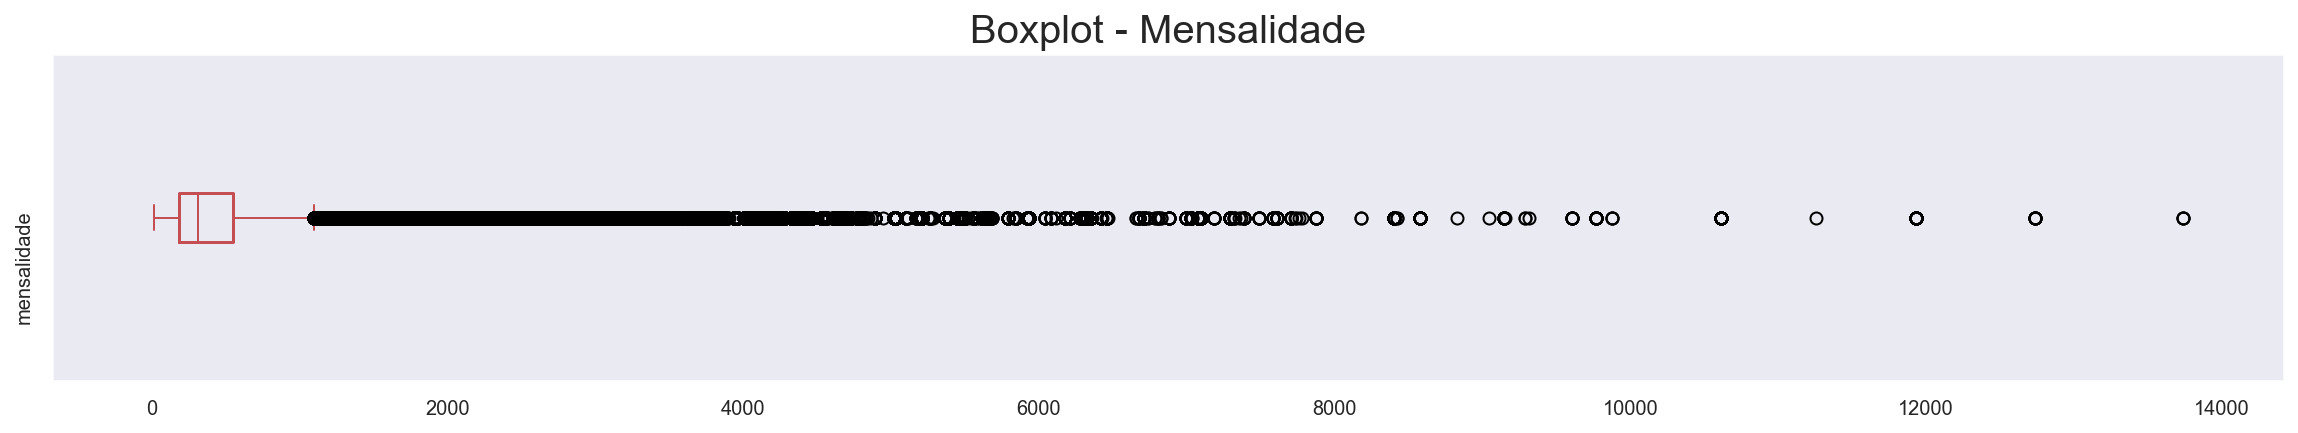

In [9]:
boxprops = dict(linestyle='-', linewidth=1.5, color = 'r')
df_original.boxplot(column=['mensalidade'], 
                vert=False, 
                grid=False,
                showfliers=True, 
                rot=90, 
                fontsize=10, 
                figsize=(20,3),
                color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
                boxprops=boxprops).set_title("Boxplot - Mensalidade", fontsize=20)

## Pré processamento dos dados

In [8]:
# Conversão atributos em dados categóricos, com exceção do valor do plano
for c in df_original.columns:
  if df_original[c].dtype != "float64":
    df_original[c] = df_original[c].astype("category")

In [10]:
# Trabalhando com uma cópia do DataFrame original
dfDados_encoder = df_original.copy()

In [11]:
# A categoria "tipo" apresenta apenas um valor, vamos retirar do contexto de análise
del dfDados_encoder['tipo']

In [12]:
# Criação dos encoders
encoders = dict()
for col in dfDados_encoder.columns[:-1]:
    le = LabelEncoder()

    # Aplica o encoder nas variáveis que estão com string
    dfDados_encoder[col] = le.fit_transform(dfDados_encoder[col])
    
    # Inclui o encoder no dicionário para posterior uso
    encoders[col]=le.classes_

# Remove valores missing eventualmente gerados
dfDados_encoder.dropna(inplace = True)

In [13]:
# Salvando os índices dos valores categóricos para uso futuro (encoders)
joblib.dump(encoders, '../model/encoders.bin', compress=True)

['../model/encoders.bin']

In [14]:
df_original.shape

(1582482, 13)

In [15]:
dfDados_encoder.shape

(1582482, 12)

#### Remoção dos valores _outliers_ da variável ``target`` com base na dispersão por log

In [16]:
dfDados_encoder['mensal_log'] = np.log1p(dfDados_encoder['mensalidade'])

Text(0.5, 1.0, 'Boxplot - Mensalidade log1p')

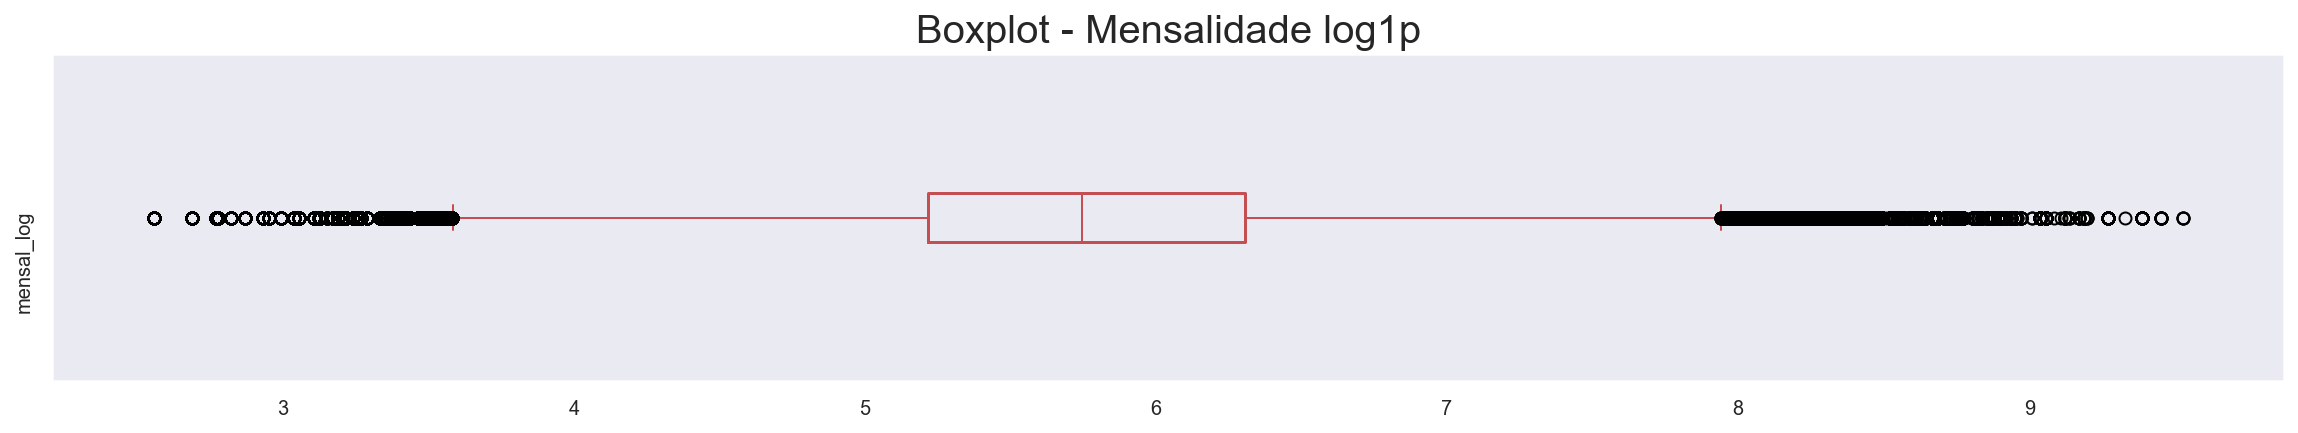

In [17]:
boxprops = dict(linestyle='-', linewidth=1.5, color = 'r')
dfDados_encoder.boxplot(column=['mensal_log'], 
                vert=False, 
                grid=False,
                showfliers=True, 
                rot=90, 
                fontsize=10, 
                figsize=(20,3),
                color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
                boxprops=boxprops).set_title("Boxplot - Mensalidade log1p", fontsize=20)

In [18]:
dfDados_encoder = dfDados_encoder[dfDados_encoder['mensal_log'].between(3.5, 8.0, inclusive=True)]

In [19]:
dfDados_encoder.shape

(1569130, 13)

Text(0.5, 1.0, 'Boxplot - Mensalidade log1p')

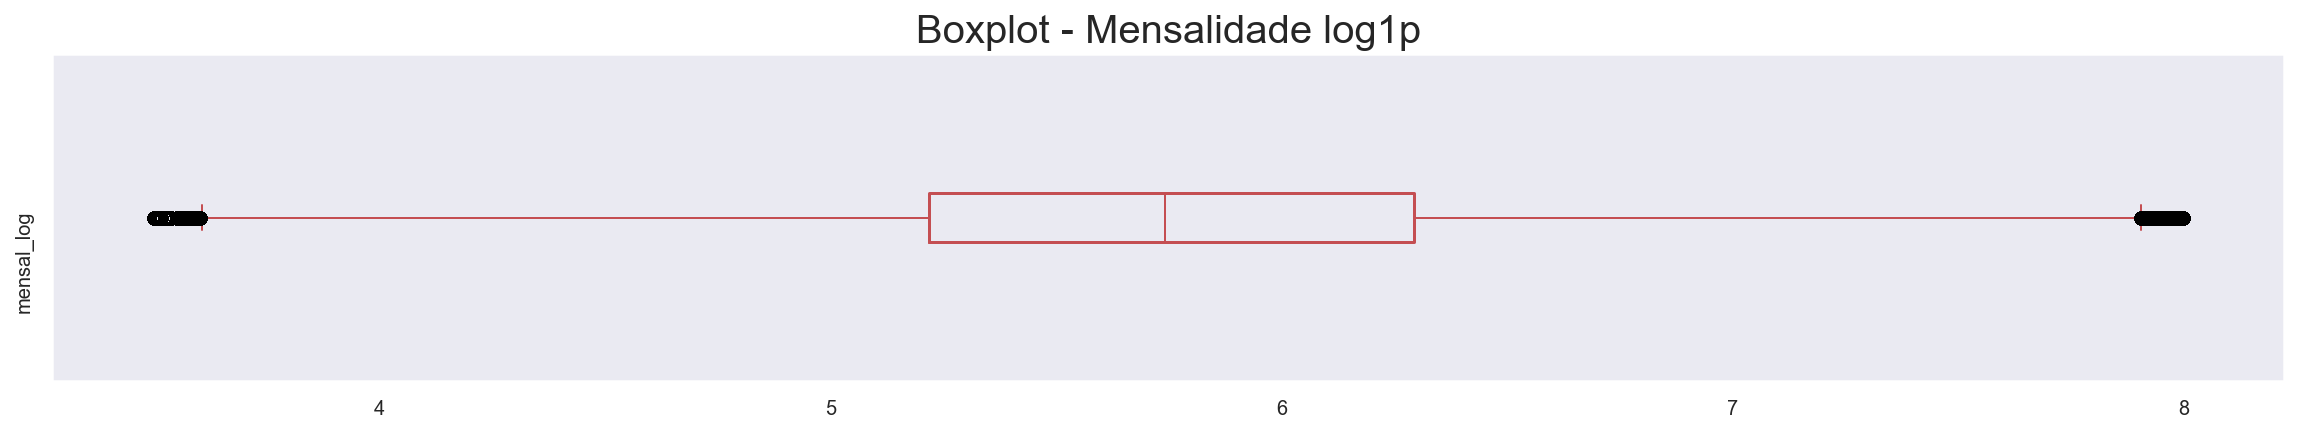

In [20]:
boxprops = dict(linestyle='-', linewidth=1.5, color = 'r')
dfDados_encoder.boxplot(column=['mensal_log'], 
                vert=False, 
                grid=False,
                showfliers=True, 
                rot=90, 
                fontsize=10, 
                figsize=(20,3),
                color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
                boxprops=boxprops).set_title("Boxplot - Mensalidade log1p", fontsize=20)

## Modelo preditivo SVM

### Preparando os dados de Treino e de Teste

In [21]:
# Gerando uma amostra só para testar se o restante do código funciona ...
# ------->> Comentar essa linha em "produção" <<------- #
dfDados_encoder = dfDados_encoder.sample(5000)

In [22]:
# Separando X e y (variáveis explanatórias da variável alvo)
X = dfDados_encoder.iloc[:, 0:11]  
y = dfDados_encoder.iloc[:, 11] 

In [23]:
# Divisão em dados de Treino e Teste.
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 69)

In [24]:
# Padronização dos dados (atributos categóricos que foram convertidos em índices)
sc = StandardScaler()
X_treino_scaled = sc.fit_transform(X_treino)
X_teste_scaled = sc.transform(X_teste)

In [25]:
# Salvando os valores de transformação para usar nos novos dados - escala
joblib.dump(sc, '../model/std_scaler.bin', compress=True)

['../model/std_scaler.bin']

In [26]:
# Resumo do treinamento do modelo - Iremos gerar um dicionário para cada modelo treinado, ao final podemos comparar
def write_dict_results(vs, Kernel, start, end, y_teste, previsoes):
    SVM_dict = {'Modelo':'SVM',
               'Versão':vs,
               'Kernel': Kernel,
               'Tempo Treino (min)' : round((end - start)/60,0),
               'MSE':mean_squared_error(y_teste, previsoes),
               'R2':r2_score(y_teste, previsoes),
               'MAE':mean_absolute_error(y_teste, previsoes),
               'EVS':explained_variance_score(y_teste, previsoes)}
    return SVM_dict

### Definição do modelo ``Base``

In [27]:
# Modelo Base
modelo_v1 = svm.SVR(kernel = 'linear')

In [28]:
# Treinamento
start = time.time()
modelo_v1.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo:', end - start)

Tempo de Treinamento do Modelo: 0.6584904193878174


In [29]:
# Previsões
previsoes_v1 = modelo_v1.predict(X_teste_scaled)

In [30]:
# Dicionário de métricas e metadados
SVM_dict_v1 = write_dict_results(1, "Linear", start, end, y_teste, previsoes_v1)

In [31]:
SVM_dict_v1

{'Modelo': 'SVM',
 'Versão': 1,
 'Kernel': 'Linear',
 'Tempo Treino (min)': 0.0,
 'MSE': 96608.95755952167,
 'R2': 0.3160487285482233,
 'MAE': 183.71988815404305,
 'EVS': 0.3553567003441772}

### GridSearchCV + Kernel RBF

In [32]:
# Definindo valores que serao testados na SVR
# kernel=[‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’]

# constante de regularizacao, testar maiores e menores que o default, se der extremos, varias mais
c_range = np.array([200.,100.,50.,10.,1.0,0.95,1.05,1.1,1.2,1.5,2,0.9,0.8]) 
# só usados para kernel polinomio, para  o resto serao ignorados
polinomio_range = np.array([2,3,4,5])
epsilon_range = np.array([0.1,0.2,0.05,0.03,0.02,0.01,0.005])
gamma_range = ['scale', 'auto']
r_range =  np.array([0.5, 1])
svm_param_grid = {"C":c_range, "degree":polinomio_range, "epsilon":epsilon_range, "gamma":gamma_range, "coef0":r_range}

In [33]:
# Cria o modelo
modelo_v2 = svm.SVR(kernel = 'rbf')

# Grid Search com 3 validações cruzadas
start = time.time()
modelo_v2_grid_search_rbf = GridSearchCV(modelo_v2, svm_param_grid, cv = 3)

# Treinamento
modelo_v2_grid_search_rbf.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo com Grid Search:', end - start)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {modelo_v2_grid_search_rbf.best_score_ :.2%}")
print(f"Hiperparâmetros Ideais: {modelo_v2_grid_search_rbf.best_params_}")

Tempo de Treinamento do Modelo com Grid Search: 3786.5262286663055
Acurácia em Treinamento: 44.16%
Hiperparâmetros Ideais: {'C': 200.0, 'coef0': 0.5, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto'}


In [34]:
# Previsões
previsoes_v2 = modelo_v2_grid_search_rbf.predict(X_teste_scaled)

In [35]:
# Dicionário de métricas e metadados
SVM_dict_v2 = write_dict_results(2, "RBF", start, end, y_teste, previsoes_v2)

### GridSearchCV + Kernel Sigmoid

In [36]:
# Cria o modelo
modelo_v3 = svm.SVR(kernel = 'sigmoid')

# Grid Search com 3 validações cruzadas
start = time.time()
modelo_v3_grid_search_rbf = GridSearchCV(modelo_v2, svm_param_grid, cv = 3)

# Treinamento
modelo_v3_grid_search_rbf.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo com Grid Search:', end - start)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {modelo_v2_grid_search_rbf.best_score_ :.2%}")
print(f"Hiperparâmetros Ideais: {modelo_v2_grid_search_rbf.best_params_}")

Tempo de Treinamento do Modelo com Grid Search: 3775.4246821403503
Acurácia em Treinamento: 44.16%
Hiperparâmetros Ideais: {'C': 200.0, 'coef0': 0.5, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto'}


In [37]:
# Previsões
previsoes_v3 = modelo_v3_grid_search_rbf.predict(X_teste_scaled)

In [38]:
# Dicionário de métricas e metadados
SVM_dict_v3 = write_dict_results(3, "Sigmoid", start, end, y_teste, previsoes_v3)

### GridSearchCV + Kernel Polinomial

In [39]:
# Cria o modelo
modelo_v4 = svm.SVR(kernel = 'poly')

# Grid Search
start = time.time()
modelo_v4_grid_search_poly = GridSearchCV(modelo_v4, svm_param_grid, cv = 3)

# Treinamento
modelo_v4_grid_search_poly.fit(X_treino_scaled, y_treino)
end = time.time()
print('Tempo de Treinamento do Modelo com Grid Search:', end - start)

# Acurácia em Treino
print(f"Acurácia em Treinamento: {modelo_v4_grid_search_poly.best_score_ :.2%}")
print(f"Hiperparâmetros Ideais: {modelo_v4_grid_search_poly.best_params_}")

Tempo de Treinamento do Modelo com Grid Search: 4222.636477470398
Acurácia em Treinamento: 46.54%
Hiperparâmetros Ideais: {'C': 50.0, 'coef0': 1.0, 'degree': 4, 'epsilon': 0.2, 'gamma': 'scale'}


In [40]:
# Previsões
previsoes_v4 = modelo_v4_grid_search_poly.predict(X_teste_scaled)

In [41]:
# Dicionário de métricas e metadados
SVM_dict_v4 = write_dict_results(4, "Polinomial", start, end, y_teste, previsoes_v4)

## Escolha do modelo preditivo SVM e gravação do treinamento

In [42]:
# Concatena todos os dicionários em um dataframe do Pandas
resumo = pd.DataFrame({'SVM_dict_v1':pd.Series(SVM_dict_v1),
                       'SVM_dict_v2':pd.Series(SVM_dict_v2),
                       'SVM_dict_v3':pd.Series(SVM_dict_v3),
                       'SVM_dict_v4':pd.Series(SVM_dict_v4)})

In [43]:
# Salvando os resultados
resumo.to_csv('../model/resumo_treinos.cvs')

In [44]:
resumo.T

,Modelo,Versão,Kernel,Tempo Treino (min),MSE,R2,MAE,EVS
SVM_dict_v1,SVM,1,Linear,0.0,96608.95756,0.316049,183.719888,0.355357
SVM_dict_v2,SVM,2,RBF,63.0,71475.165832,0.493986,149.176883,0.515438
SVM_dict_v3,SVM,3,Sigmoid,63.0,71475.165832,0.493986,149.176883,0.515438
SVM_dict_v4,SVM,4,Polinomial,70.0,67655.560937,0.521027,146.504438,0.537713


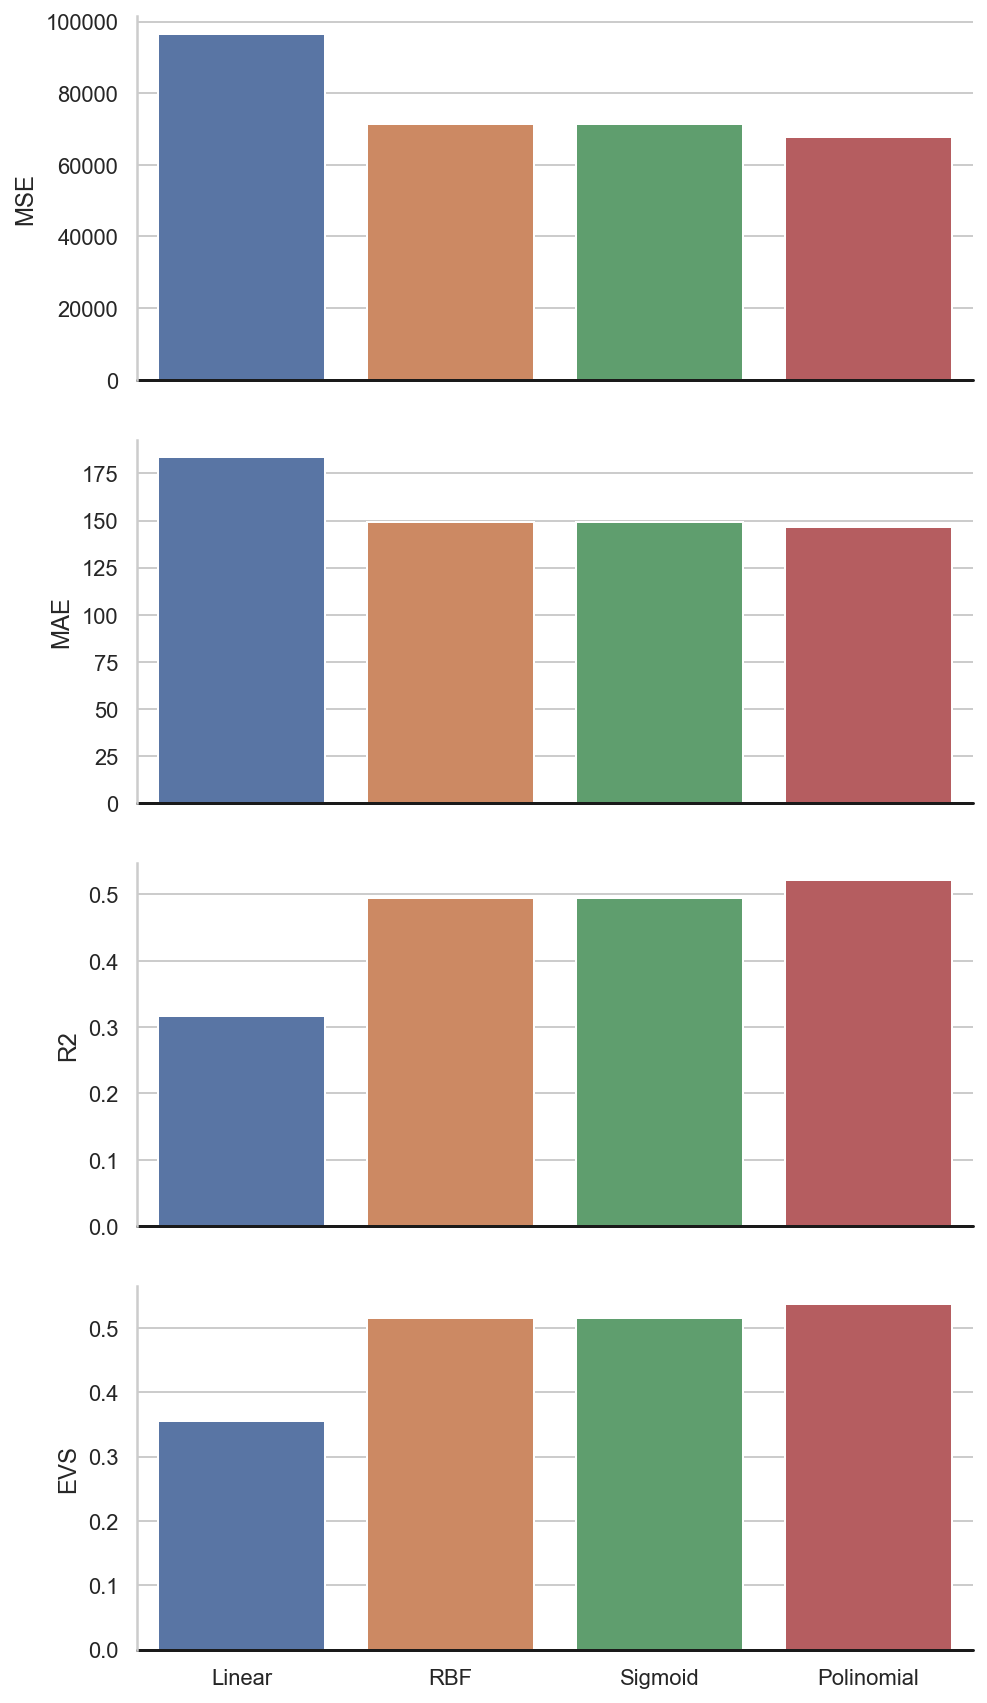

In [45]:
# Comparação dos resultados de maneira gráfica
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure
f, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(7, 12), sharex=True)

x=np.array(resumo.T['Kernel'])

sns.barplot(x=x, y=resumo.T['MSE'], palette="deep", orient = 'v', ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("MSE")

sns.barplot(x=x, y=resumo.T['MAE'], palette="deep", orient = 'v', ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("MAE")

sns.barplot(x=x, y=resumo.T['R2'], palette="deep", orient = 'v', ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("R2")

sns.barplot(x=x, y=resumo.T['EVS'], palette="deep",orient = 'v',  ax=ax4)
ax4.axhline(0, color="k", clip_on=False)
ax4.set_ylabel("EVS")

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

In [46]:
# Salvando os modelos de previsão
joblib.dump(modelo_v1, '../model/svm_linear_v1.bin', compress=True)
joblib.dump(modelo_v2_grid_search_rbf, '../model/svm_rbf_v2.bin', compress=True)
joblib.dump(modelo_v3_grid_search_rbf, '../model/svm_sigmoid_v3.bin', compress=True)
joblib.dump(modelo_v4_grid_search_poly, '../model/svm_poly_v4.bin', compress=True)

['../model/svm_poly_v4.bin']

---

## Utilização do modelo para novas previsões

- Devemos utilizar o ``encode``, isto é, a conversão dos índices dos valores categóricos em numéricos. No início do Jupyter salvamos esse dicionário onde a chave representa no nome da variável explanatória e o valor (do dicionário) é um array com os possíveis valores observados na massa de dados para esse atributo;
- Além do _encode_ precisamos aplicar a escala aos dados, isto é a função ``StandardScaler()`` registrada e gradava no objeto ``sc`` que foi utilizada para os dados de treino do modelo (o modelo foi treinado com uma escada diferente da apresentada pelos índices do encode por questões de melhoria de performance do modelo SVM)
- Por fim, devemos apresentar ao modelo o novo dado no mesmo formato do dado utilizado durante o treinamento

In [ ]:
# Recuperando o encoder utilizado no pré-processamento dos dados
encoders=joblib.load('../model/encoders.bin')

In [47]:
encoders

{'ano_mes': array(['2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01',
        '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07',
        '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01',
        '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07',
        '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01',
        '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
        '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01',
        '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
        '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01',
        '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07'],
       dtype=object),
 'contratacao': array(['Coletivo por adesão', 'Individual ou familiar'], dtype=object),
 'segmentacao': array(['Ambulatorial', 'Ambulatorial e Hospitalar', 'Hospitalar'],
       dtype=object),
 'in_odonto': array([0, 1], dtype

In [68]:
sample = [encoders['ano_mes'][58], encoders['contratacao'][1], encoders['segmentacao'][1], encoders['in_odonto'][0], 
          encoders['in_obstetricia'][1], encoders['abrangencia'][2], encoders['fator'][1], encoders['acomodacao'][1],
          encoders['internacao'][1], encoders['cd_faixa_etaria'][7], encoders['nm_regiao'][3]]

In [69]:
sample

['2020-06',
 'Individual ou familiar',
 'Ambulatorial e Hospitalar',
 0,
 1,
 'Grupo de municípios',
 'Co-participação',
 'Individual',
 'Parcial com internação',
 8,
 'Sudeste']

In [88]:
[encoders[k].tolist().index(v) for k, v in zip(encoders.keys(), sample)]

[58, 1, 1, 0, 1, 2, 1, 1, 1, 7, 3]

In [ ]:
# Recuperando a transformação de escala dos dados utilizado no treinemento
sc=joblib.load('../model/std_scaler.bin')

In [89]:
# Geração de um novo conjunto de variáveis explanatórias para previsão da mensalidade

# List Comprehension para leitura dos índices dos encoders, com base na lista "sample"
novo_x = [encoders[k].tolist().index(v) for k, v in zip(encoders.keys(), sample)]

# Transformação de dimensão desse array gerado (devemos apresentar o mesmo formato ao modelo)
novo_x = np.array(novo_x).reshape(1, -1)

# Aplicação da escala aos dados "novos" com base nos valores de conversão para os dados de treino
novo_x_scaled = sc.transform(novo_x)

In [90]:
# Array que deve ser apresentado ao modelo
novo_x_scaled

array([[ 0.97676461,  1.34498653,  0.05933101, -0.16703337,  0.33121287,
        -0.48883928,  0.34774244,  0.60015966,  1.64301919,  0.86856931,
         0.41029804]])

In [100]:
# Recuperando o modelo salvo
modelo = joblib.load('../model/svm_sigmoid_v3.bin')

In [101]:
# previsões da mensalidade com base nos dados
previsao_novo_x = modelo.predict(novo_x_scaled)
np.round(previsao_novo_x,2)[0]

600.92

### Tabela de Código da faixa etária

*	(01) 00 (zero) a 18 (dezoito) anos;
*	(02) 19 (dezenove) a 23 (vinte e três) anos;
*	(03) 24 (vinte e quatro) a 28 (vinte e oito) anos;
*	(04) 29 (vinte e nove) a 33 (trinta e três) anos;
*	(05) 34 (trinta e quatro) a 38 (trinta e oito) anos;
*	(06) 39 (trinta e nove) a 43 (quarenta e três) anos;
*	(07) 44 (quarenta e quatro) a 48 (quarenta e oito) anos;
*	(08) 49 (quarenta e nove) a 53 (cinquenta e três) anos;
*	(09) 54 (cinquenta e quatro) a 58 (cinquenta e oito) anos;
*	(10) 59 (cinquenta e nove) anos ou “mais”.

In [106]:
# Vamos melhorar esse sistema de previsão
def how_much (attrs):
        a = np.array([encoders[k].tolist().index(v) for k, v in zip(encoders.keys(), attrs)]).reshape(1, -1)
        a = sc.transform(a)
        val = modelo.predict(a)
        return np.round(val,2)[0]

In [108]:
how_much(['2018-06', 'Coletivo por adesão', 'Ambulatorial', 1, 1, 'Nacional',
          'Franquia', 'Coletiva', 'Parcial com internação', 4, 'Norte'])

308.34

In [122]:
how_much(['2020-07', 'Individual ou familiar', 'Ambulatorial', 0, 1, 'Nacional',
          'Co-participação', 'Coletiva', 'Total', 10, 'Sudeste'])

470.67

In [124]:
how_much(['2020-07', 'Coletivo por adesão', 'Ambulatorial', 0, 1, 'Nacional',
          'Co-participação', 'Coletiva', 'Total', 10, 'Sudeste'])

436.73

In [126]:
how_much(['2020-07', 'Coletivo por adesão', 'Ambulatorial', 0, 1, 'Estadual',
          'Co-participação', 'Coletiva', 'Total', 10, 'Nordeste'])

345.77

In [8]:
"_".join( ['teste', 'e']).upper()

'TESTE_E'